<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# импортируем библиотеку пандас
import pandas as pd 
# импортируем библиотеку для работы с датой и временем
import datetime as dt
# импорптируем библиотеку для работы с графиками
import matplotlib.pyplot as plt 
#Импортируем библиотеку сеаборн для построения множественных графиков.
import seaborn as sns
# импортируем библиотеку для расчета дисперсии и стандартного отклонения
import numpy as np 
# импортируем библиотеку для метрики
from sklearn.metrics import mean_squared_error, make_scorer
# импортируем библиотеку для разделение на выборки, кроссвалидацию 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
# импортируем библиотеку для решающего дерева
from sklearn.tree import DecisionTreeRegressor
# импортируем библиотеку для градиентного бустинга
from lightgbm import LGBMRegressor
# импортируем библиотеку для кодировки категорий
from sklearn.preprocessing import OrdinalEncoder, StandardScaler  

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
print(df.info())
display(df.head())
display(df.describe())
print('Уникальные значения')
display(df.nunique())
print('Пропуски')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Уникальные значения


DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Пропуски


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Для определения цены (Price) у нас есть следующие параметры:
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя 

Все параметры, кроме параметров дат и времени, имеют правильные форматы. 

Параметры *DateCrawled, DateCreated, PostalCode, LastSeen* не влияют на цену автомобиля. Параметр NumberOfPictures содержит одно уникальное значение, которое равняется 0, то есть тоже можно откинуть для увеличения скорости и точности обучения.
Параметр *DateCrawled* и *DateCreated* переведем в тип date_time чтобы отсеять выбросы по году регистрации авто.

Параматры *VehicleType, Gearbox, Model, FuelType, NotRepaired* содержат пропуски и их практически невозможно восстановить. Например, некоторые машины шли в разных кузовах под одним названием, коробка передач могла быть разная для одного двигателя, как и сам двигатель мог быть разный для одинаковой мощности и коробки. Но часть данных попытаемся восстановить.

У 'Price', 'RegistrationYear', 'Power' есть аномальные значения.

In [3]:
data = df.drop(['NumberOfPictures', 'LastSeen', 'PostalCode'], axis=1)
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d')
data.shape

(354369, 13)

In [4]:
# Отсеям объявления с датой и времнем регистрации более позднее выгрузки 
# и объявления с годом выпуска авто позднее даты регистрации объявления
data = data.query(
    '(DateCreated <= DateCrawled) and ((DateCreated.dt.year > RegistrationYear) or ((DateCreated.dt.year == RegistrationYear) and (DateCreated.dt.month >= RegistrationMonth)))')
data.shape

(334609, 13)

In [5]:
# Удалим DateCrawled и DateCreated за ненадобностью
data = data.drop(['DateCreated', 'DateCrawled', 'RegistrationMonth'], axis=1)
data.shape

(334609, 10)

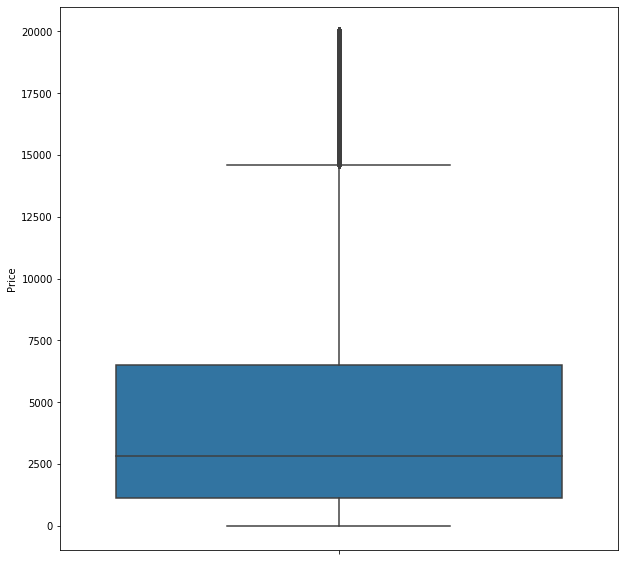

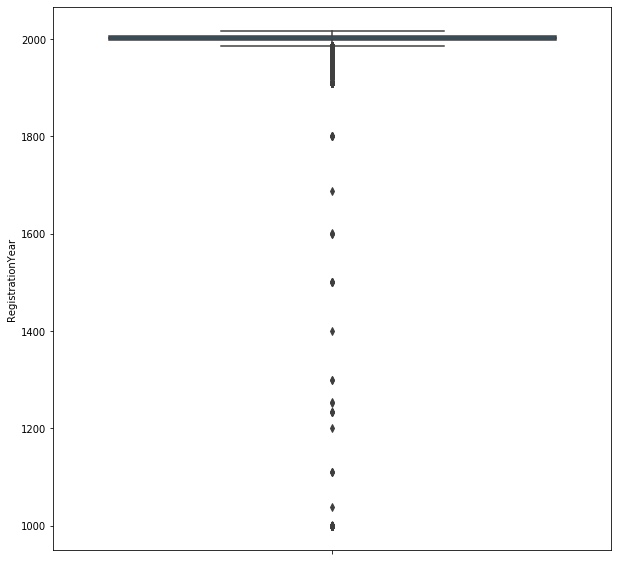

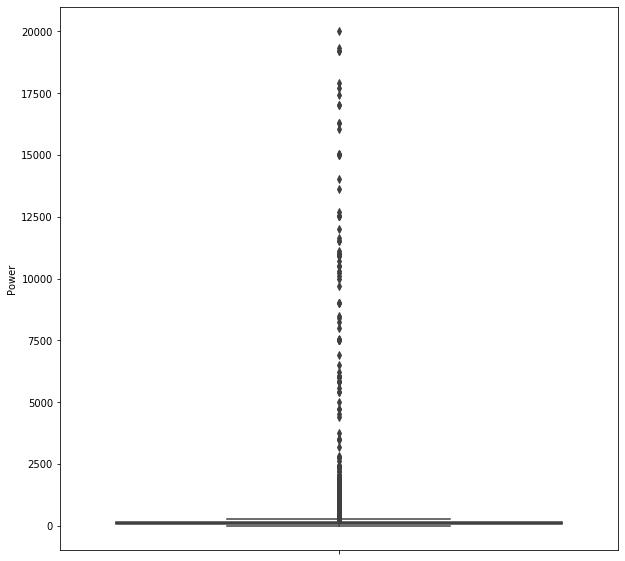

In [6]:
# Посмотрим на выбросы в данных
names = ['Price', 'RegistrationYear', 'Power']

for i in names:
    plt.figure(figsize=(10,10))
    sns.boxplot(data=data, y=i)
    plt.show()
    

По цене аномальными можно считать цены, которые менее 100 у.е.
У года регистрации все таже остаются аномальные значения.
Мощность тоже имеет аномальные значения, возможно это из-за ошибки заполнения анкеты, или сбоя форматов данных (то есть вместо 20000 должно быть 200,00 л.с.). А вот значения мощности с нулевыми значениями нужно отсечь, так как это либо машины на запчасти, что нам не интересно, либо ошибка в данных. Мощность двигателя важна, она сильно влияет на цену, например, в россии цена на авто с мощность двигателя более 250 л.с. ниже, чем цена такого же автомобиля но с мощностью менее 250 л.с. из-за транспортного налога.

In [7]:
# отбросим данные с годом регистрации менее 1910
# так как год регистрации невозможно восстановить по другим показателям
# отбросим данные с мощностью двигателя
# Отсчем нулевые значения мощности, максимальная 600 у бмв M
# так как мощность невозможно восстановить по другим данным из-за разных значений у одной модели одного года с одним двигателем 
data = data.query('1910 <= RegistrationYear and 0 < Power < 600 and Price > 99')
print('Потеряли данных {:.2%}'.format(1- data.shape[0] / df.shape[0]))

Потеряли данных 17.70%


Данных потеряли слишком много, но ничего не поделать, такие данные можно восстановить только вручную.

In [8]:
# Посмотрим типы топлива
data['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

gasoline и petrol - это одно и тоже бензин

In [9]:
# заменим gasoline на petrol
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol') 
data['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [10]:
display(data.isnull().sum())

Price                   0
VehicleType          7121
RegistrationYear        0
Gearbox              5065
Power                   0
Model               10638
Kilometer               0
FuelType            13714
Brand                   0
NotRepaired         41058
dtype: int64

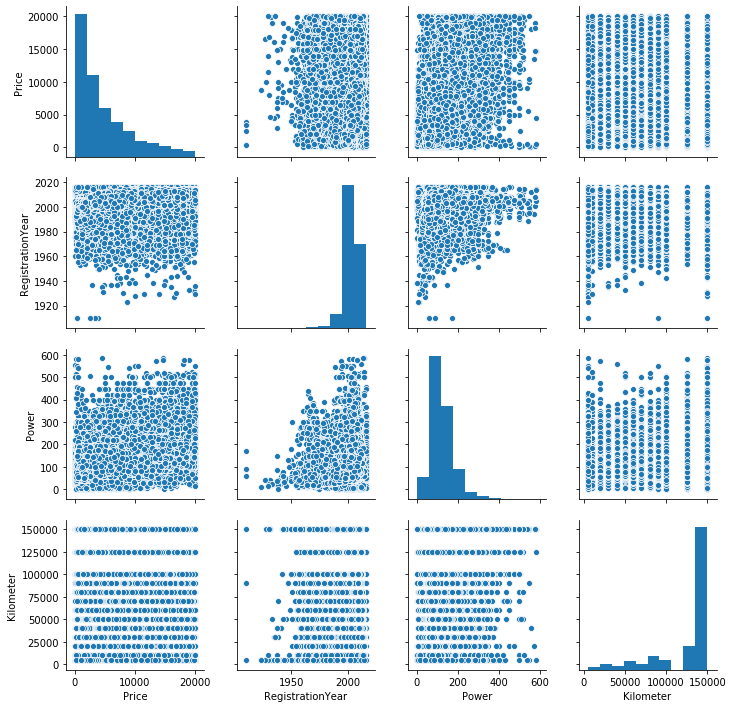

In [11]:
# Построим матрицу зависимостей
sns.pairplot(data)
plt.show()

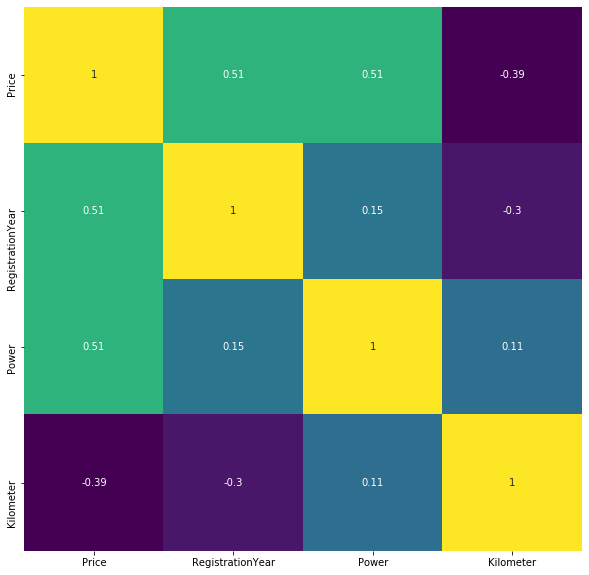

In [12]:
# Построим матрицу корреляций
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), cbar=False, annot=True, cmap='viridis')
plt.show()

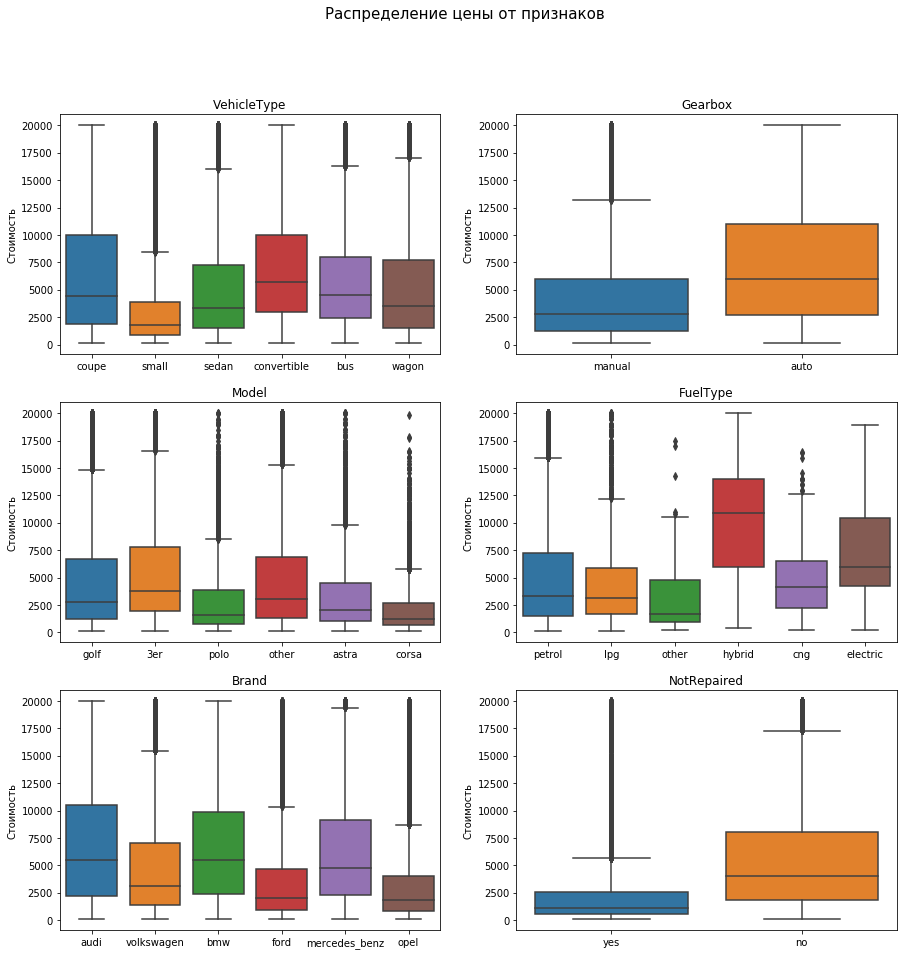

In [13]:
#Зависимость цены от категориальных переменных
data_col_obj = data.select_dtypes(include='object').columns
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Распределение цены от признаков', fontsize=15)
axs = axs.ravel()
for i, col in enumerate(data_col_obj):
    data_top = data[col].value_counts().head(6).index.array
    sns.boxplot(x=col, y='Price', data=data.query(col + ' in @data_top'), ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_title(col, fontsize=12)
    axs[i].set_ylabel('Стоимость')
plt.show()

**Вывод**

Начальные данные слишком "сырые". В них много пропусков и аномалий. Явные аномалии, влияющие на цену, мы удалили. Пропуски мы оставили, изменив на nan. Такие данные крайне сложно восстановить из-за того что автомобили выпускаются годами, а то и десятилетиями, на одном авто одного года могут быть установленные разные двигатели по типу топлива или по мощности, так и кузов автомобиля может быть разный у автомобиля с одной маркой, названием и годом выпуска.

На цену сильнее всего влияют: год регистрации, мощность, тип кпп, тип топлива, бренд и отсутствие ремонтов.

Чем моложе автомобиль, тем он дороже, так же и с мощностью. Авто на автомате дороже, чем на механической кпп. Гибридны авто самы дорогие, далее идут электрические автомобили и потом все остальные, это объясняется желанием снизить вред окружающей среде но недостаточной инфраструктурой для электротранспорта. Немецка тройка Ауди, Бмв и Мерседес-Бенц является самой дорогой, но между собой они имеют похожий разброс цен. Ожидаемо авто без ремонтов стоят ощутимо дороже ремонтированных.

Таким образом гибридное авто немецкой тройки без ремонтов является самым дорогим.

In [14]:
display(data.isnull().sum())

Price                   0
VehicleType          7121
RegistrationYear        0
Gearbox              5065
Power                   0
Model               10638
Kilometer               0
FuelType            13714
Brand                   0
NotRepaired         41058
dtype: int64

## Обучение моделей

Возьмем 2 модели: LightGBM и дерево решений.

LightGBM является моделью градиентного бустинга, мощная и сложная модель предсказывания. А в противовес её дерево решений как относительно быстрый метод предсказывания.

In [15]:
# Для начала разобьем данные на признаки и цель
features = data.drop(['Price'], axis=1)
target = data['Price']
# Разобъем данные на 2 выборки: обучающую (75%) и тестовую (25%). То есть 3:1. 
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.75, random_state=12345) 
print('Количество объектов в обучающей выборке', len(features_train))
print('Количество объектов в тестовой выборке', len(features_test))

Количество объектов в обучающей выборке 218742
Количество объектов в тестовой выборке 72914


In [16]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
231443,wagon,2009,manual,105,logan,150000,petrol,dacia,no
291650,bus,2010,manual,140,touran,80000,petrol,volkswagen,no
243815,wagon,2003,manual,135,laguna,150000,lpg,renault,no
215577,NaN,2005,manual,140,a3,150000,NaN,audi,NaN
264777,wagon,2009,auto,170,c_klasse,80000,petrol,mercedes_benz,no


In [17]:
# Так как дерево решений не умеет работать с категориальными данными напрямую, то преобразуем их
col = data.select_dtypes(include='object').columns
encoder = OrdinalEncoder() 
features_enc = features.copy().fillna('nan')
encoder.fit(features_enc[col]) 
features_enc[col] = pd.DataFrame(encoder.transform(features_enc[col]), columns=col, index = features_enc.index)
features_train_enc = features_train.copy().fillna('nan')
features_train_enc[col] = pd.DataFrame(encoder.transform(features_train_enc[col]), columns=col, index = features_train_enc.index)
features_test_enc = features_test.copy().fillna('nan')
features_test_enc[col] = pd.DataFrame(encoder.transform(features_test_enc[col]), columns=col, index = features_test_enc.index)
features_train_enc.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
231443,8.0,2009,1.0,105,142.0,150000,6.0,6.0,1.0
291650,0.0,2010,1.0,140,222.0,80000,6.0,38.0,1.0
243815,8.0,2003,1.0,135,136.0,150000,3.0,27.0,1.0
215577,3.0,2005,1.0,140,28.0,150000,4.0,1.0,0.0
264777,8.0,2009,0.0,170,59.0,80000,6.0,20.0,1.0


In [18]:
# Масштабируем все признаки так как разброс по километражу значительно больше разброса по мощности
# Для LightGBM только численные признаки
col = ['RegistrationYear', 'Power', 'Kilometer']
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features[col]) 
features_train[col] = scaler.transform(features_train[col])
features_test[col] = scaler.transform(features_test[col])
display(features_train.head())

# Для решающего дерева все признаки
scaler_enc = StandardScaler()
scaler_enc.fit(features_enc)
features_train_enc = pd.DataFrame(
    scaler_enc.transform(features_train_enc), columns=features_enc.columns, index = features_train.index)
features_test_enc = pd.DataFrame(
    scaler_enc.transform(features_test_enc), columns=features_enc.columns, index = features_test.index)
display(features_train_enc.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
231443,wagon,0.988048,manual,-0.294318,logan,0.593074,petrol,dacia,no
291650,bus,1.143975,manual,0.355390,touran,-1.308265,petrol,volkswagen,no
243815,wagon,0.052485,manual,0.262574,laguna,0.593074,lpg,renault,no
215577,NaN,0.364339,manual,0.355390,a3,0.593074,NaN,audi,NaN
264777,wagon,0.988048,auto,0.912282,c_klasse,-1.308265,petrol,mercedes_benz,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
231443,1.216952,0.988048,0.425835,-0.294318,0.453705,0.593074,0.251778,-1.097651,0.091372
291650,-2.038358,1.143975,0.425835,0.355390,1.589855,-1.308265,0.251778,1.294148,0.091372
243815,1.216952,0.052485,0.425835,0.262574,0.368493,0.593074,-4.594613,0.471967,0.091372
215577,-0.817617,0.364339,0.425835,0.355390,-1.165309,0.593074,-2.979149,-1.471370,-1.970298
264777,1.216952,0.988048,-1.905152,0.912282,-0.725051,-1.308265,0.251778,-0.051239,0.091372


In [19]:
# Создадим функцию для метрики RMSE, которая явлется квадратным корнем из MSE
def rmse(real, predictions):
    return mean_squared_error(real, predictions) ** .5

In [20]:
# Переведенным данные типа object в категории для адекватной работы LightGBM
data_col_obj = data.select_dtypes(include='object').columns
for col in data_col_obj:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

**LGBMRegressor**

In [21]:
# создадим модель градиентного бустинга
lgbmr = LGBMRegressor(metric='rmse', verbose_eval=0, seed=12345)

# добавим кросс-валидацию
cv = KFold(n_splits=5, shuffle=True, random_state=12345)
params = {
    'learning_rate': np.logspace(-3, 2, 3),
    'max_depth': [20, 23, 25],
    'num_leaves': [20, 36, 61],
}

grid_lgbmr = GridSearchCV(lgbmr,
                        params,
                        cv=cv,
                        scoring=make_scorer(rmse, greater_is_better=False),
                        n_jobs=2
                       )

In [22]:
%%time
# обучим модель и выведем время обучения
grid_lgbmr.fit(features_train, target_train)
print('Параметры лучшей модели:', grid_lgbmr.best_params_) 
print('RMSE лучшей модели:', -grid_lgbmr.best_score_)
print('Время выполнения')

Параметры лучшей модели: {'learning_rate': 0.31622776601683794, 'max_depth': 23, 'num_leaves': 61}
RMSE лучшей модели: 1552.184137418364
Время выполнения
CPU times: user 10.1 s, sys: 616 ms, total: 10.7 s
Wall time: 5min 18s


**DecisionTreeRegressor**

In [23]:
# Создадим модель решающего дерева, параметры кросс валидации оставим прежними
dtr = DecisionTreeRegressor(random_state=12345)

params_dtr = {
    'max_depth': range (27, 33, 1),
    'min_samples_leaf': range (6, 10, 1),
}

grid_dtr = GridSearchCV(dtr,
                        params_dtr,
                        cv=cv,
                        scoring=make_scorer(rmse, greater_is_better=False),
                        n_jobs=2
                        )

In [24]:
%%time
# обучим модель и выведем время обучения
grid_dtr.fit(features_train_enc, target_train)
print('Параметры лучшей модели:', grid_dtr.best_params_) 
print('RMSE лучшей модели:', -grid_dtr.best_score_)
print('Время выполнения')

Параметры лучшей модели: {'max_depth': 30, 'min_samples_leaf': 7}
RMSE лучшей модели: 1749.6201674529864
Время выполнения
CPU times: user 1.74 s, sys: 273 ms, total: 2.01 s
Wall time: 1min 33s


**Вывод**

                      RMSE	  Время
        LightGBM 	1552.2	 12.5с
    DecisionTree	 1749.6	 2.1с

Градиентный бустинг показывает лучше результат, чем решающее дерево. Однако, время обучения и нахождения гипер параметров сильно больше. Необходимо узнать у заказчика максимальное время обучения. Если время его не удовлетворит, то можно использовать более мощное железо, чтобы снизить время.

## Анализ моделей

Проверим наши модели на тестовых выборках

**LGBMRegressor**

In [25]:
%%time
lgbmr_pred = grid_lgbmr.best_estimator_.predict(features_test)
print('RMSE:', rmse(target_test, lgbmr_pred))

RMSE: 1544.0816887632589
CPU times: user 1.03 s, sys: 4.74 ms, total: 1.03 s
Wall time: 1.01 s


**DecisionTreeRegressor**

In [26]:
%%time
dtr_pred = grid_dtr.best_estimator_.predict(features_test_enc)
print('RMSE:', rmse(target_test, dtr_pred))

RMSE: 1729.417286392074
CPU times: user 22.4 ms, sys: 7.68 ms, total: 30.1 ms
Wall time: 76.4 ms


**Адекватность модели**

In [27]:
%%time
# Посчитаем RMSE на средних данных данных 
pred = [target.mean()] * len(target_test)
print('RMSE:', rmse(target_test, pred))

RMSE: 4596.841400166543
CPU times: user 4.19 ms, sys: 8.08 ms, total: 12.3 ms
Wall time: 10.6 ms


**Вывод**

                      RMSE	  Время
        LightGBM 	1544.1	 0.933с
    DecisionTree	 1729.4	 0.031с
            mean     4596.8     0.011c
    
Ожидаемо градиентный бустинг показывает результат лучше. Однако на предсказывания уходит практически в 5 раз большее времени.
Чтобы снизить время, требуется увеличение мощности или уменьшить величену  гиперпаматеров, что снизит качество предсказаний.

Для снижения RMSE требуется увеличение количества признаков, например, цвет авто, количество владельцев, также нужно увеличить качество самих данных. Или же усложнить модель, но есть риск переобучения. Наши модели обучены хорошо и адекватно, переобучени не наблюдается и RMSE намного меньше чем у простой модели с заполнением данных средним значением.

## Вывод

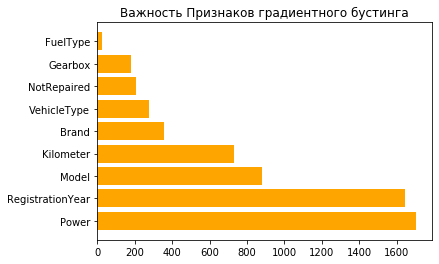

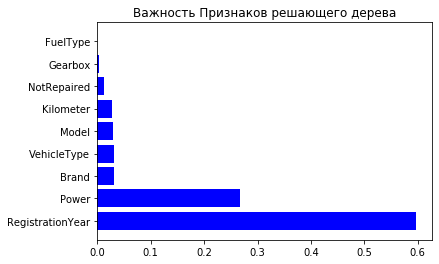

In [28]:
# Посмотрим какие признаки оказались
importances = grid_lgbmr.best_estimator_.feature_importances_
feature_list = list(features.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

plt.barh(y = range(feature_results.shape[0]),      # значение шкалы оси Y гистограммы
        width = feature_results['importance'],               # значение оси x гистограммы
        tick_label = feature_results['feature'],     # метку шкалы для оси Y гистограммы
        color = 'orange',               # цвет заливки гистограммы
       )

plt.title('Важность Признаков градиентного бустинга')
plt.show() 

importances1 = grid_dtr.best_estimator_.feature_importances_
feature_results1 = pd.DataFrame({'feature': feature_list,'importance': importances1})
feature_results1 = feature_results1.sort_values('importance',ascending = False).reset_index(drop=True)
plt.barh(y = range(feature_results1.shape[0]),      # значение шкалы оси Y гистограммы
        width = feature_results1['importance'],               # значение оси x гистограммы
        tick_label = feature_results1['feature'],     # метку шкалы для оси Y гистограммы
        color = 'blue',               # цвет заливки гистограммы
       )

plt.title('Важность Признаков решающего дерева')
plt.show() 

В данном проекте мы построили 2 модели предсказания стоимости автомобиля, для этого нам потребовалось провести глубокую предобработку входных данных из-за огромного содержания пропусков и аномальных значений. Пропуски и аномалии встречаются даже в самых важных, на мой взгляд, параметров, которые непосредственно влияют на цену, например, тип КПП, мощность.

В основном мы удаляли данные, однако существуют способы их частичного восстановления, но требуется подключение каталога всех автомобилей. Однако полностью данные восстановить не получится, потому что, например, автомобиль BMW 3er был сразу в 4х типах кузова: седан, купе, универсал, кабриолет, а также имел бензиновый и дизельный двигатели одной мощности но с разными КПП. Однако Opel Corsa выпускался только в 1 кузове small (или хэтчбек), но опять же КПП с одним двигателем могла идти разная.

Для текущих данных мы получили:

                      RMSE	  Время     RMSE(обуч.)	Время обучения
        LightGBM 	1544.1	 0.933с     1552.2	        12.5с
    DecisionTree	 1729.4	 0.031с     1749.6	         2.1с
            mean     4596.8     0.011c

Самыми важными признаками оказались: мощность и год регистрации в обоих моделях. Для градиентного бустинга дополнительно важны модель и пробег, остальные признаки менее важны, а вот тип топлива практически не влияет, хотя электрические модели и гибридные значительно дороже остальных, но ввиду малого количества в выборке не оказывают заметного влияния.

Чтобы снизить RMSE можно пойти 2мя путями:
 1. Увеличить значение гипер параметров, но увеличится время предсказания и обучения и возможно начнется переобучение.
 2. Улучшить качество входных данных и колчество признаков.

Для снижения времени обучения и предсказания требуется либо увеличение мощности железа, на котором происходит обучение, либо снижение величины гиперпараметров, но снизится качество модели и повысится RMSE.

Для снижения влияния человеческого фактора требуется заводить vin авто. По vin можно можно сразу однозначно сказать цвет автомобиля, тип кузова, силовую установку, количество владльцев, дату выпуска авто, количество аварий (оффициальных) и даже пробег и комплектацию. Пользователю нужно будет загрузить только фотографии и подправить данные, например если не удалось найти пробег в базах автомастерских и неофициальные ремонты.